# Part 2 - Forecasting Black Swan Events in the Financial Markets

### Modelling Approach for Part 2: Forecasting Tail Risk and “Black Swan” Conditions

In Part 1 we showed that S&P 500 daily returns are **non-normal, heavy-tailed, and exhibit clustering of extremes**. Classical Gaussian time-series models are therefore miscalibrated for risk. In Part 2, the goal is not to predict the exact date of the next crash (a true “black swan” in Taleb’s sense), but to **forecast the time-varying risk of extreme moves** – i.e. when the market is statistically more fragile.

Based on the literature and our empirical findings, we will use two complementary approaches:

1. **GARCH(1,1) with Student’s t innovations (GARCH-t) on S&P 500 returns**  
   - Financial returns are known to exhibit **volatility clustering** and **fat tails**. The GARCH family (Bollerslev, 1986) is the standard framework for modeling time-varying volatility, while many studies find that assuming **Student’s t residuals** substantially improves fit and tail risk estimation relative to Gaussian errors (e.g. Hansen, 1994; Cont, 2001).  
   - This directly matches our Part 1 results: we saw that a static Student’s t distribution fits the marginal distribution of returns much better than a Normal and yields realistic VaR and worst-day probabilities. Embedding this same heavy-tailed distribution into a **dynamic GARCH model** allows us to forecast a **conditional return distribution** for each day, from which we can compute:  
     - one-day-ahead **conditional volatility**,  
     - model-implied **VaR** at high confidence levels (e.g. 99%, 99.9%), and  
     - the **probability of an extreme loss** (e.g. \( P(r_{t+1} < -5\%) \)).  
   - This GARCH-t framework is widely used in both academia and practice for risk management, because it jointly captures **time-varying volatility** and **heavy tails**, which we have already identified as key stylised facts of S&P 500 returns.

2. **Including the VIX index and realised volatility as complementary risk indicators**  
   - The **CBOE VIX index** is often described as the market’s “fear gauge”: it reflects **option-implied volatility** for the S&P 500 and tends to spike during crises. Empirical work shows that VIX is highly informative about perceived risk and crash probability, especially in stressed markets.  
   - To keep the project tractable, we will not build a full multivariate model, but we will **align and merge**:  
     - S&P 500 daily log returns (`SPX_Return`),  
     - the **VIX level** and its daily changes (`VIX_Close`, `VIX_Return`), and  
     - simple **realised volatility estimates** (e.g. 10-day and 20-day rolling standard deviation of returns).  
   - We will then use these series to:  
     - compare the **GARCH-t conditional volatility** with VIX and realised volatility over time (do they spike together around 2008, 2011, 2020?), and  
     - optionally, define a **“high-risk regime” indicator** based on combinations of high modelled volatility, high VIX, and high realised volatility. This provides an intuitive way to interpret our forecasts: even if we cannot predict the exact crash date, we can identify periods where **tail risk is elevated**, consistent with the idea of entering a more fragile “Fourth Quadrant” environment.

These choices are deliberately **parsimonious**: they are strongly grounded in the literature on financial time series, directly aligned with our Part 1 evidence (heavy tails, clustering, misfit of Gaussian models), and simple enough to implement and interpret clearly in a Masters-level project. In the following sections, we will (i) construct the merged dataset (S&P 500, VIX, realised volatility), (ii) estimate a GARCH-t model for `SPX_Return`, and (iii) use it to generate **dynamic tail-risk forecasts** and compare them with realised market stress episodes.


## Import Data

In [ ]:
%pip install yfinance

S&P 500 sample:
Price       SPX_Adj_Close    SPX_Close  SPX_Return
Date                                              
2005-01-04    1188.050049  1188.050049   -0.011740
2005-01-05    1183.739990  1183.739990   -0.003634
2005-01-06    1187.890015  1187.890015    0.003500
2005-01-07    1186.189941  1186.189941   -0.001432
2005-01-10    1190.250000  1190.250000    0.003417

VIX sample:
Price       VIX_Adj_Close  VIX_Close  VIX_Return
Date                                            
2005-01-04          13.98      13.98   -0.007128
2005-01-05          14.09      14.09    0.007838
2005-01-06          13.58      13.58   -0.036867
2005-01-07          13.49      13.49   -0.006649
2005-01-10          13.23      13.23   -0.019462

Final merged dataset (first rows):
Price       SPX_Adj_Close    SPX_Close  SPX_Return  VIX_Adj_Close  VIX_Close  \
Date                                                                           
2005-02-01    1189.410034  1189.410034    0.006867          12.03      12.0

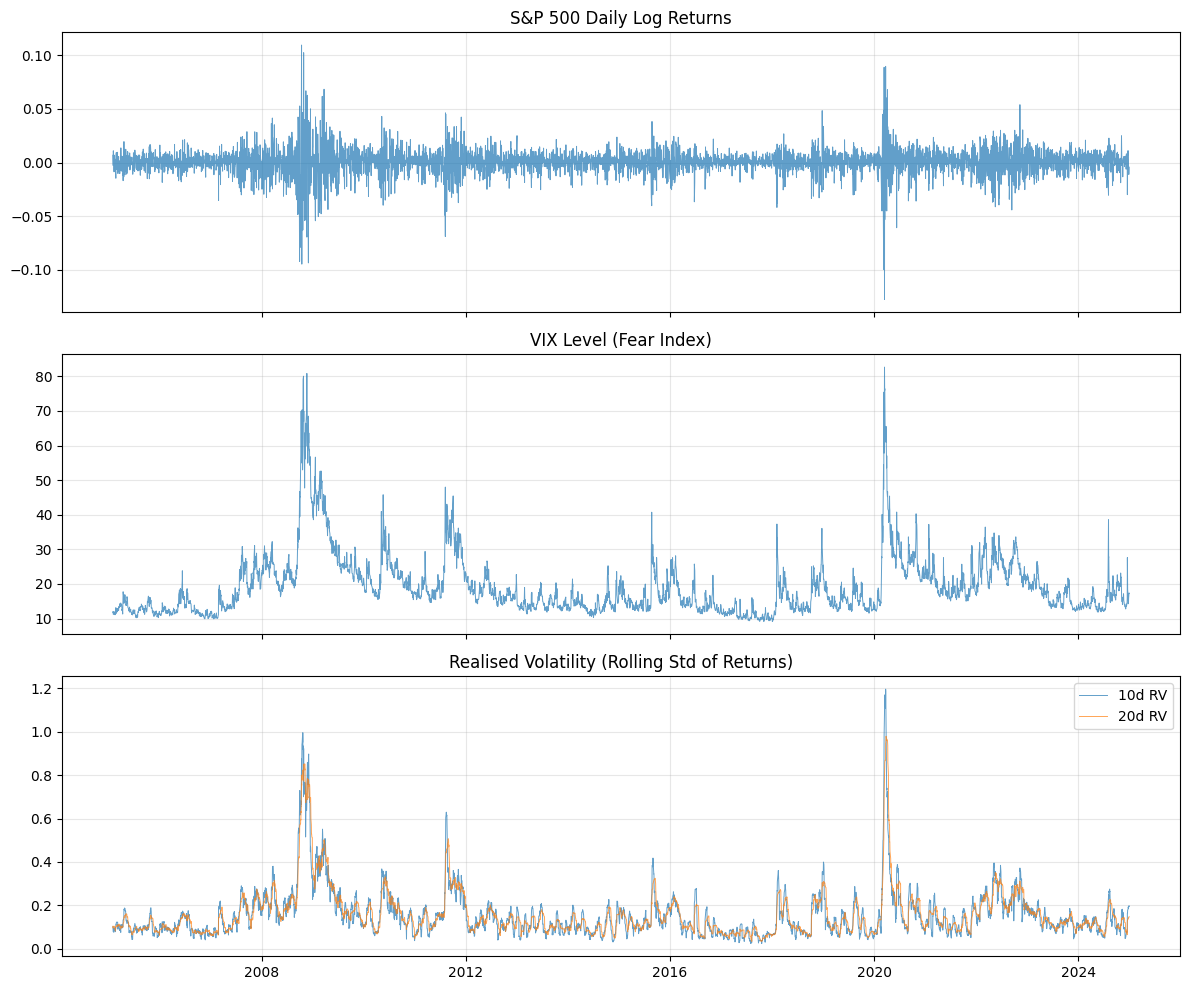

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. PARAMETERS
# ==========================================
spx_ticker = "^GSPC"
vix_ticker = "^VIX"
start_date = "2005-01-01"
end_date   = "2025-01-01"

# ==========================================
# 2. DOWNLOAD S&P 500 DATA
# ==========================================
spx = yf.download(spx_ticker, start=start_date, end=end_date,
                  progress=False, auto_adjust=False)

# Flatten multiindex columns if present
spx.columns = spx.columns.get_level_values(0)

# Compute daily log returns
spx["SPX_Return"] = np.log(spx["Adj Close"] / spx["Adj Close"].shift(1))

# Keep what we need
spx = spx[["Adj Close", "Close", "SPX_Return"]].rename(
    columns={
        "Adj Close": "SPX_Adj_Close",
        "Close": "SPX_Close"
    }
)

# Drop first NaN return
spx = spx.dropna(subset=["SPX_Return"])

print("S&P 500 sample:")
print(spx.head())

# ==========================================
# 3. DOWNLOAD VIX DATA (FEAR / VOLATILITY GAUGE)
# ==========================================
vix = yf.download(vix_ticker, start=start_date, end=end_date,
                  progress=False, auto_adjust=False)

vix.columns = vix.columns.get_level_values(0)

# Use Adj Close or Close as VIX level
vix = vix[["Adj Close", "Close"]].rename(
    columns={
        "Adj Close": "VIX_Adj_Close",
        "Close": "VIX_Close"
    }
)

# VIX daily log changes (proxy for shocks to fear)
vix["VIX_Return"] = np.log(vix["VIX_Adj_Close"] / vix["VIX_Adj_Close"].shift(1))

vix = vix.dropna(subset=["VIX_Return"])

print("\nVIX sample:")
print(vix.head())

# ==========================================
# 4. MERGE INTO A SINGLE DATAFRAME
# ==========================================
# Inner join on dates so we only keep days where we have both SPX and VIX
df = pd.merge(
    spx,
    vix,
    left_index=True,
    right_index=True,
    how="inner"
)

# Optional: sort index just in case
df = df.sort_index()

# ==========================================
# 5. OPTIONAL EXTRA FEATURES (USEFUL LATER)
# ==========================================

# Rolling realised volatility of SPX (10-day window, annualised)
df["SPX_RV_10d"] = df["SPX_Return"].rolling(10).std() * np.sqrt(252)

# Rolling realised volatility of SPX (20-day window, annualised)
df["SPX_RV_20d"] = df["SPX_Return"].rolling(20).std() * np.sqrt(252)

# Drop initial NaNs from rolling windows
df = df.dropna()

print("\nFinal merged dataset (first rows):")
print(df.head())

print("\nColumns in df:")
print(df.columns)

# ==========================================
# 6. QUICK PLOTS (OPTIONAL SANITY CHECK)
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

axes[0].plot(df.index, df["SPX_Return"], lw=0.7, alpha=0.7)
axes[0].set_title("S&P 500 Daily Log Returns")
axes[0].grid(True, alpha=0.3)

axes[1].plot(df.index, df["VIX_Close"], lw=0.7, alpha=0.7)
axes[1].set_title("VIX Level (Fear Index)")
axes[1].grid(True, alpha=0.3)

axes[2].plot(df.index, df["SPX_RV_10d"], lw=0.7, alpha=0.7, label="10d RV")
axes[2].plot(df.index, df["SPX_RV_20d"], lw=0.7, alpha=0.7, label="20d RV")
axes[2].set_title("Realised Volatility (Rolling Std of Returns)")
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()


### Feature description

For Part 2, we work with a unified daily dataset that combines **price, return, and volatility information** for the S&P 500 and the VIX. Each row corresponds to a trading day between 2005 and 2025. The main features are:

- **`SPX_Close` / `SPX_Adj_Close`**  
  These are the raw and adjusted closing levels of the S&P 500 index.  
  - We mainly use these to compute returns and for plotting price levels over time.  
  - The adjusted close accounts for corporate actions (like dividends), so it is the right base for log-return calculations.

- **`SPX_Return`**  
  This is the **daily log return** of the S&P 500, computed from `SPX_Adj_Close`.  
  $$
  r_t = \log\left(\frac{\text{AdjClose}_t}{\text{AdjClose}_{t-1}}\right)
  $$ 
  - This is the **core series** we model with GARCH-t.  
  - All our tail-risk forecasts (VaR, crash probabilities) will be derived from the conditional distribution of `SPX_Return`.

- **`VIX_Close` / `VIX_Adj_Close`**  
  These are the daily closing levels of the **CBOE VIX index**, often called the market’s “fear gauge”.  
  - VIX reflects **option-implied volatility** for the S&P 500 over the next 30 days.  
  - High VIX levels typically indicate heightened uncertainty and elevated crash risk.  
  - We use VIX as a **market-based risk indicator** to compare against our model-implied volatility and tail risk.

- **`VIX_Return`**  
  Daily log change in the VIX level.  
  - Large positive `VIX_Return` values correspond to **sudden spikes in fear/uncertainty**, which often coincide with or precede equity sell-offs.  
  - This can be used descriptively (e.g., highlighting stress episodes) or as an optional predictor in extended models.

- **`SPX_RV_10d` and `SPX_RV_20d`**  
  These are **realised volatility estimates** computed as rolling standard deviations of `SPX_Return` over 10- and 20-day windows, annualised:
  $$
  \text{RV}_{k,t} = \sqrt{252} \cdot \text{StdDev}(r_{t-k+1}, \dots, r_t)
  $$
  - They provide a **backward-looking measure** of how volatile the market has been recently.  
  - We use them mainly for comparison with our **forward-looking GARCH-t volatility** and the VIX. When all three (GARCH volatility, realised volatility, and VIX) are elevated, it is a strong signal that the market is in a **high-risk regime**.

Together, these features give us a compact but rich view of market conditions:  
- `SPX_Return` for the **returns we want to model**,  
- VIX to capture the **market’s own expectation of risk**, and  
- realised volatility to summarise **recent turbulence**. 

## 2.1 Forecasting using GARCH

### **Important Note:** The parameters are estimated based on all of the data. The predictions are done using these parameters but using only previous data.
### Quentin will do a more complex version with a rolling window parameter estimation.

#### Why GARCH(1,1) and not a higher-order GARCH?

In Part 2 we will use a **GARCH(1,1)** model for S&P 500 daily returns. The choice of (1,1) is not arbitrary: in practice, GARCH(1,1) is the **workhorse specification** in financial econometrics, and there are both empirical and practical reasons to prefer it over more complicated GARCH(p,q):

- **It already captures the key stylised fact: volatility clustering.**  
  The GARCH(1,1) variance equation
  $$
  \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2
  $$
  says that today’s volatility depends on **yesterday’s shock** and **yesterday’s volatility**. Empirically, for equity index returns, this simple structure is usually enough to reproduce the slowly decaying autocorrelation in squared returns that we observe in the data.

- **Higher-order GARCH rarely adds much in-sample or out-of-sample.**  
  When researchers estimate GARCH(p,q) with larger p and q on stock index returns, they typically find that the extra lag coefficients are small and often not statistically significant, while the sum \(\alpha + \beta\) is still close to 1. In other words, GARCH(1,1) often fits **about as well** as GARCH(2,2) or higher, but with fewer parameters and less risk of overfitting.

- **Parsimony and interpretability.**  
  This is a small Masters project, not a full-blown model selection exercise. GARCH(1,1) gives you:
  - a clear interpretation of parameters ($\alpha$ = sensitivity to new shocks, $\beta$ = persistence),
  - a model that is **standard and widely recognised** in the literature and industry,
  - and a structure that extends cleanly to **GARCH-t** (just changing the error distribution to Student’s t) without making estimation fragile.

- **Our main innovation is in the *distribution*, not the GARCH order.**  
  Part 1 already showed that the biggest miss in classical models is the **assumption of Normality**, not the lack of a GARCH(2,2) term. Moving from Normal to **Student’s t** (and later using that inside GARCH) dramatically improves tail risk estimation and VaR calibration. Changing from GARCH(1,1) to GARCH(2,1) or GARCH(2,2) would have a much smaller impact on our conclusions.

For these reasons, GARCH(1,1) is a natural baseline: it is **empirically adequate**, **parsimonious**, and **perfectly aligned** with the goals of this project (capturing time-varying volatility and heavy tails) without unnecessary complexity.


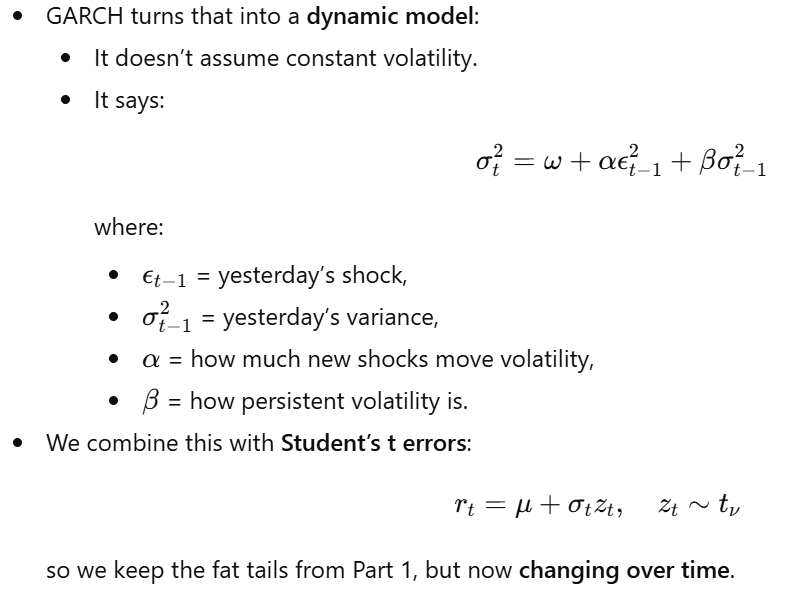

In [2]:
%pip install arch

   ---------------------------------------- 0.0/930.4 kB ? eta -:--:--
   ---------------------------------------- 10.2/930.4 kB ? eta -:--:--
   - ------------------------------------- 41.0/930.4 kB 495.5 kB/s eta 0:00:02
   ------ --------------------------------- 153.6/930.4 kB 1.1 MB/s eta 0:00:01
   ------------- -------------------------- 307.2/930.4 kB 1.9 MB/s eta 0:00:01
   -------------------- ------------------- 481.3/930.4 kB 2.3 MB/s eta 0:00:01
   -------------------------------------- - 890.9/930.4 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------- 930.4/930.4 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from arch import arch_model

In [4]:
ret = df["SPX_Return"].dropna() * 100  # convert to percent returns

print(f"Sample size for GARCH: {len(ret)} observations")
print(ret.head())

Sample size for GARCH: 5013 observations
Date
2005-02-01    0.686727
2005-02-02    0.317293
2005-02-03   -0.276947
2005-02-04    1.098252
2005-02-07   -0.108956
Name: SPX_Return, dtype: float64


### Specify the model and look at the summary

In [5]:
# Define the model
am = arch_model(
    ret,
    mean="Constant",   # r_t = mu + ...
    vol="GARCH",       # sigma_t^2 = ...
    p=1, q=1,          # GARCH(1,1)
    dist="StudentsT"   # heavy-tailed errors as in Part 1
)

# Fit the model
res = am.fit(update_freq=20, disp="off")  # update_freq just controls printing during optimisation
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   SPX_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6532.82
Distribution:      Standardized Student's t   AIC:                           13075.6
Method:                  Maximum Likelihood   BIC:                           13108.2
                                              No. Observations:                 5013
Date:                      Tue, Dec 02 2025   Df Residuals:                     5012
Time:                              17:29:18   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Interpreting the GARCH(1,1)–t Estimates

The estimated GARCH(1,1)–t model behaves very much in line with what we expect for equity index returns. The mean parameter `mu ≈ 0.087` (in percent) corresponds to an average daily return of about 0.087%, or roughly 22% per year, which is statistically significant but not central to our analysis. The volatility parameters are more interesting: `alpha[1] ≈ 0.135` shows that about 13.5% of yesterday’s squared shock feeds directly into today’s variance (large return shocks have an immediate impact on volatility), while `beta[1] ≈ 0.860` indicates that around 86% of yesterday’s variance carries over to today. Their sum `alpha + beta ≈ 0.996` is extremely close to 1, implying very **persistent volatility**: once volatility spikes in a crisis, it decays only slowly over time (the half-life of a volatility shock is on the order of several months).

The Student’s t degrees-of-freedom parameter `nu ≈ 5.6` confirms that the model’s innovations are **strongly heavy-tailed**. A t-distribution with this ν has kurtosis well above 3, meaning it assigns much higher probability to extreme shocks than a Normal distribution. This matches our Part 1 finding that even after modelling volatility clustering, the residual shocks are not Gaussian. Overall, the estimates suggest that the GARCH(1,1)–t model captures both **volatility clustering** and **fat-tailed shocks**, making it a suitable dynamic framework for the tail-risk forecasting we carry out in the next steps.


### Extract conditional volatility and put back in df

In [6]:
# Conditional volatility (daily, in %)
cond_vol_pct = res.conditional_volatility  # same index as ret

# Create a copy aligned with df
df["GARCH_vol_daily_pct"] = cond_vol_pct / 1.0  # still daily %

# Annualise: sigma_annual ≈ sigma_daily * sqrt(252)
df["GARCH_vol_annual"] = df["GARCH_vol_daily_pct"] / 100.0 * np.sqrt(252)

# For clarity, ensure realised vol columns are named nicely
df["RV_10d_ann"] = df["SPX_RV_10d"]      # already annualised from earlier
df["RV_20d_ann"] = df["SPX_RV_20d"]


### Visualize - Does GARCH react to crises?

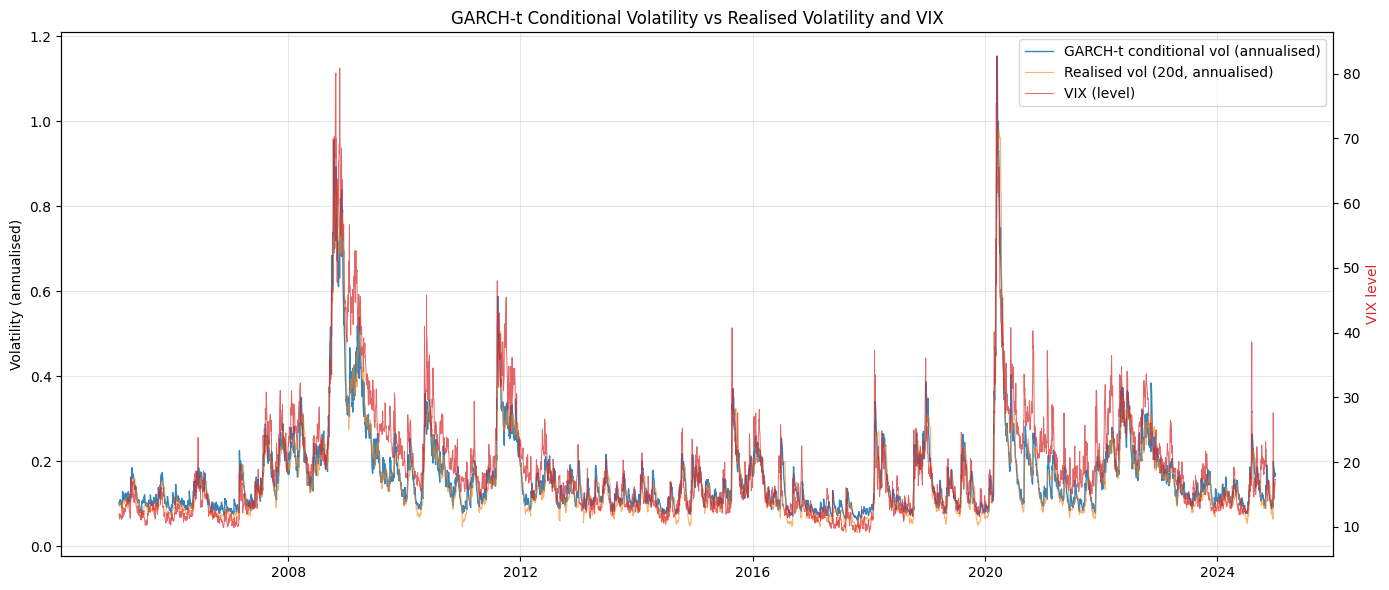

In [7]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: volatilities
ax1.plot(df.index, df["GARCH_vol_annual"], label="GARCH-t conditional vol (annualised)", lw=1.0, alpha=0.9)
ax1.plot(df.index, df["RV_20d_ann"],      label="Realised vol (20d, annualised)",      lw=0.8, alpha=0.6)
ax1.set_ylabel("Volatility (annualised)", color="black")
ax1.grid(True, alpha=0.3)

# Right axis: VIX
ax2 = ax1.twinx()
ax2.plot(df.index, df["VIX_Close"], color="tab:red", lw=0.7, alpha=0.7, label="VIX (level)")
ax2.set_ylabel("VIX level", color="tab:red")

# Build combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("GARCH-t Conditional Volatility vs Realised Volatility and VIX")
plt.tight_layout()
plt.show()


### Why Extract Conditional Volatility and Compare It to Realised Volatility and VIX?

The main output of a GARCH model is not the mean return, but the **time-varying conditional volatility** series $\sigma_t$. For each day, the model tells us how uncertain it thinks the *next* return is, given what has happened so far. This conditional volatility is the key input for everything we do next in Part 2: it feeds directly into **forecasted return distributions**, **Value-at-Risk**, and **crash probabilities**. Without $\sigma_t$, a GARCH model would collapse back to the constant-volatility world we already know is unrealistic.

Extracting the conditional volatility and plotting it over time lets us check whether the model is behaving sensibly. We compare it to:

- **Realised volatility** (rolling standard deviation of past returns), and  
- The **VIX index**, which is an option-implied, forward-looking volatility measure.

If the GARCH-t model is capturing the right dynamics, its conditional volatility should **spike in the same periods** where realised volatility is high and VIX is elevated (e.g. 2008, 2011, 2015, 2018, 2020). This visual comparison acts as a **sanity check**: it tells us whether the model “sees” the same crisis regimes that markets and simple historical measures do. It also makes the results easier to interpret: when GARCH volatility, realised volatility, and VIX are all high at the same time, we can confidently say the market is in a **high-risk state**, which is exactly the environment where tail-risk forecasting and black-swan awareness are most important.



### 2.2 From Volatility to Tail-Risk Forecasts: Dynamic Crash Probabilities
**Question:** Given today’s information, how likely does the model think a crash is tomorrow?

- **What we do:**  
  - Pick a **crash threshold** (e.g. daily return < −5%).  
  - For each day, use the fitted GARCH-t parameters to compute  
    $ P(r_{t+1} < -5\%) = F_{t_\nu}((c-\mu)/\sigma_{t+1}) $,  
    where $F_{t_\nu}$ is the Student’s t CDF.  
  - Store this as a time series `CrashProb_5pct` and plot it over time.
- **Why:**  
  - This turns abstract volatility into a **direct, interpretable tail-risk measure**: “probability of a crash tomorrow”.
- **What we can say:**  
  - “The model-implied probability of a −5% crash is near zero in calm markets, but rises sharply during known crises (2008, 2011, 2015, 2018, 2020), showing that the GARCH-t model endogenously signals periods of heightened tail risk.”

---


Crash probability summary (P[r_{t+1} < -5%]):
count    5012.000000
mean        0.006647
std         0.022838
min         0.000011
25%         0.000168
50%         0.000642
75%         0.003245
max         0.255935
Name: CrashProb_5pct, dtype: float64

Number of realised -5% crash days: 20


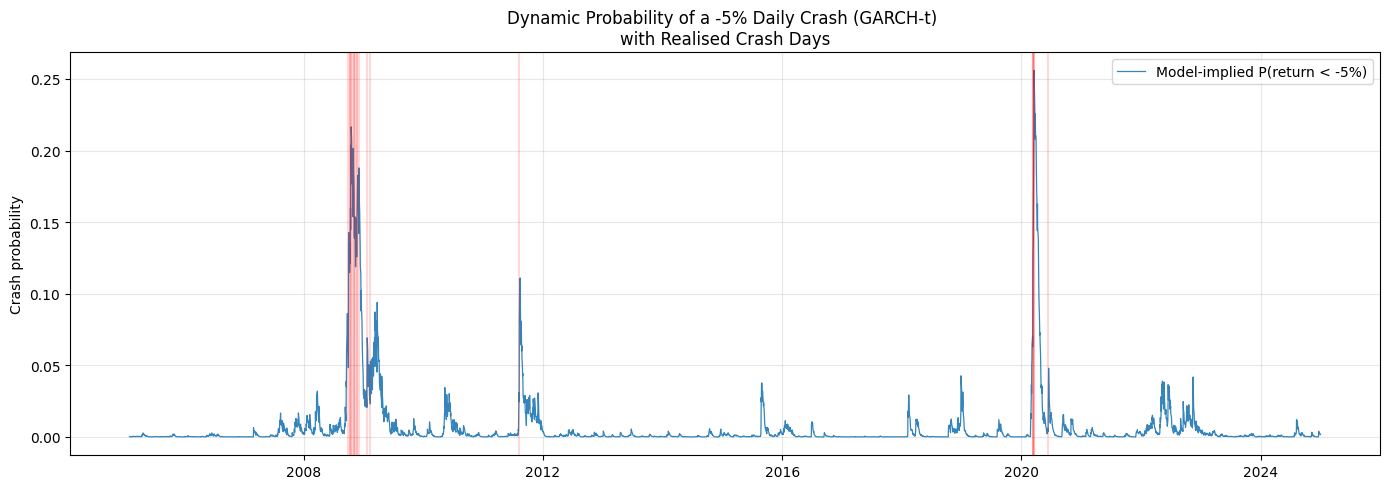

In [9]:
from scipy.stats import t as student_t

# Returns in % (same scale as used in the GARCH estimation)
ret_pct = df["SPX_Return"] * 100

# 1) Get in-sample conditional volatility from the fitted model
#    This is sigma_t for each day in the estimation sample (in % units)
sigma_t_pct = res.conditional_volatility
sigma_t_pct.name = "sigma_t_pct"

# Join into df (align on dates)
df = df.join(sigma_t_pct, how="left")

# 2) Treat today's sigma_t as the forecast for tomorrow's risk:
#    sigma_f_pct at time t is sigma_{t|t-1} = sigma_t shifted by 1
df["sigma_f_pct"] = df["sigma_t_pct"].shift(1)

# 3) Define what we mean by a "crash" – here, a daily loss worse than -5%
crash_threshold = -5.0  # -5% daily return

# Extract the estimated mean and degrees of freedom from the GARCH-t model
params = res.params
mu_hat = params["mu"]    # mean return (in %)
nu_hat = params["nu"]    # Student's t degrees of freedom

# Only compute probabilities where we have a forecasted sigma
mask = df["sigma_f_pct"].notna()

# z_cut = (c - mu) / sigma_{t+1|t}
z_cut = (crash_threshold - mu_hat) / df.loc[mask, "sigma_f_pct"]

# Crash probability series: P(r_{t+1} < -5%) given information up to t
crash_prob = student_t.cdf(z_cut, df=nu_hat)

df.loc[mask, "CrashProb_5pct"] = crash_prob

print("\nCrash probability summary (P[r_{t+1} < -5%]):")
print(df["CrashProb_5pct"].describe())

# 4) Define realised crashes for evaluation/plotting
df["Crash_5pct"] = (ret_pct <= crash_threshold).astype(int)
print("\nNumber of realised -5% crash days:", df["Crash_5pct"].sum())

# 5) Plot dynamic crash probability and mark realised crashes
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(df.index[mask],
        df.loc[mask, "CrashProb_5pct"],
        lw=0.9, alpha=0.9,
        label="Model-implied P(return < -5%)")

ax.set_ylabel("Crash probability")
ax.grid(True, alpha=0.3)

# Mark actual crash days as faint vertical red lines
for d in df.index[df["Crash_5pct"] == 1]:
    ax.axvline(d, color="red", alpha=0.15)

plt.title("Dynamic Probability of a -5% Daily Crash (GARCH-t) \nwith Realised Crash Days")
plt.legend()
plt.tight_layout()
plt.show()

### Zoom on 2008 and 2020

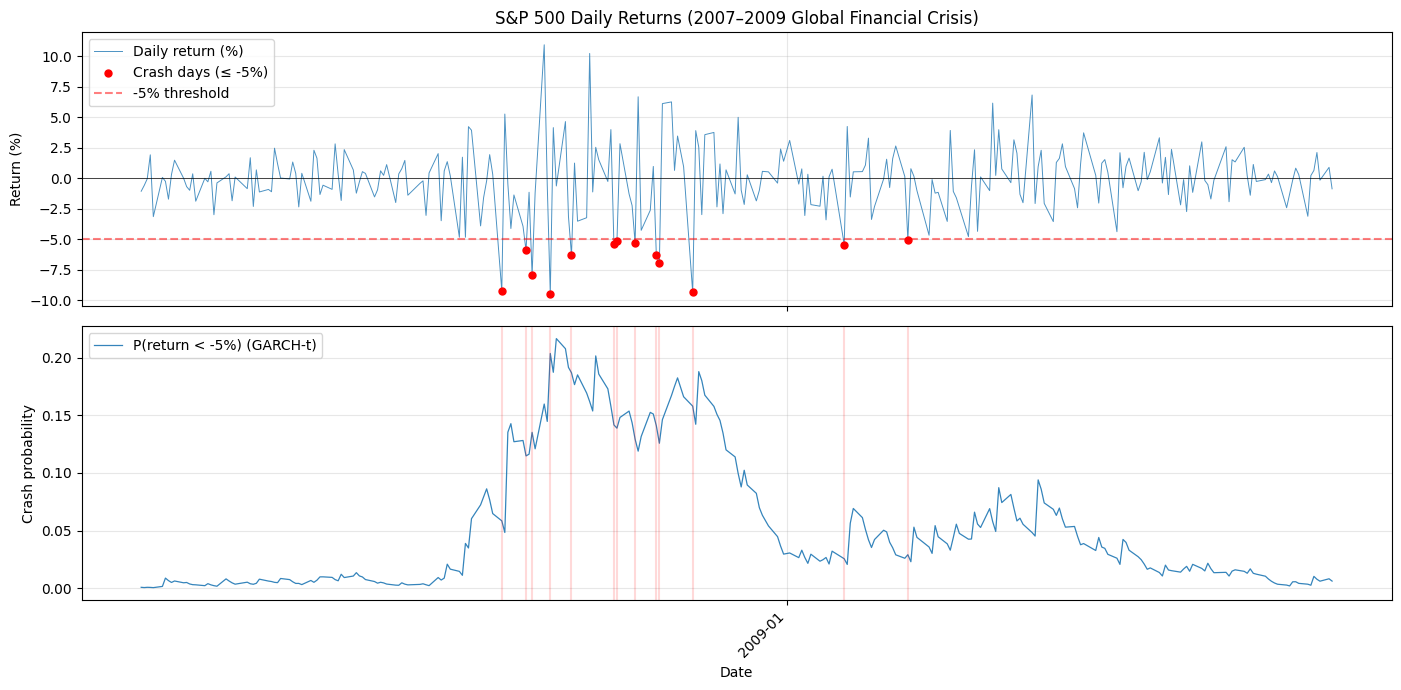

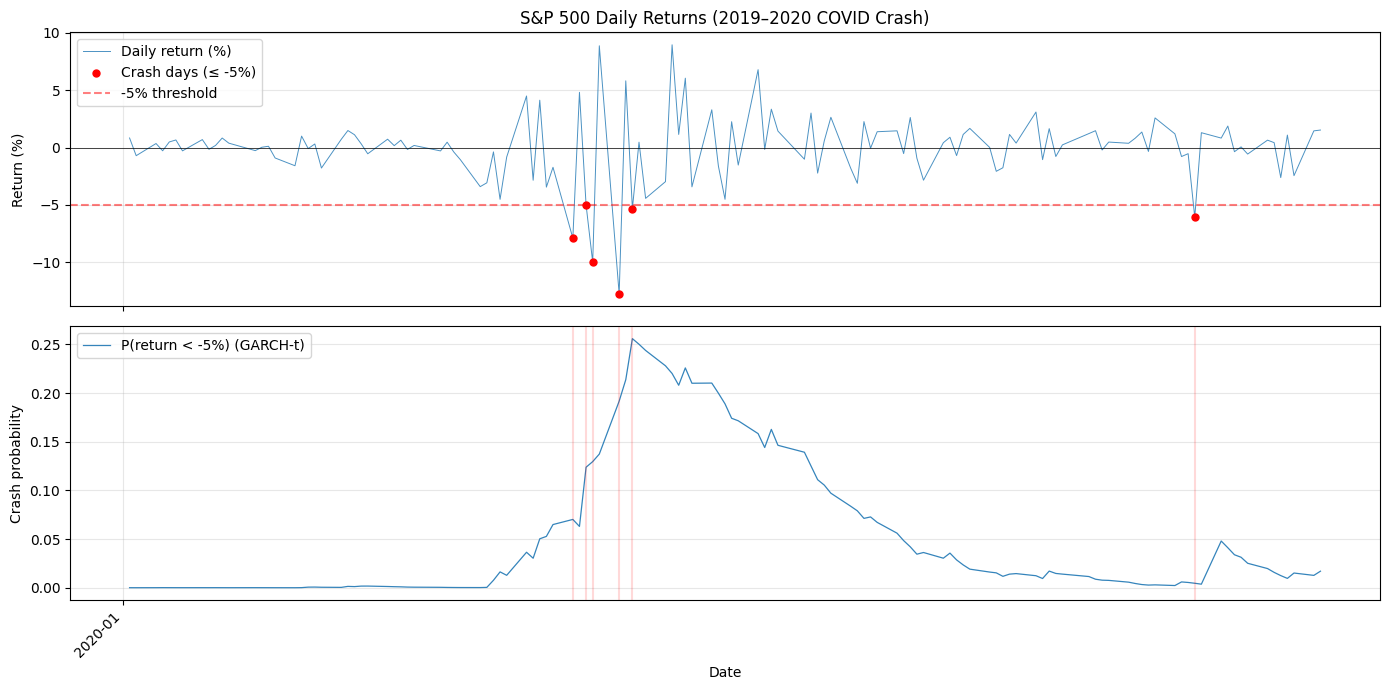

In [12]:
import matplotlib.dates as mdates

# Helper: nice plotting function for a given date window
def plot_crash_window(df, start, end, title_suffix=""):
    # Subset the data
    df_zoom = df.loc[start:end].copy()
    
    # Work in % returns for readability
    ret_pct_zoom = df_zoom["SPX_Return"] * 100
    
    # Mask where crash probability is defined
    mask = df_zoom["CrashProb_5pct"].notna()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    
    # -------------------------
    # Top panel: returns (%)
    # -------------------------
    ax1 = axes[0]
    ax1.plot(df_zoom.index, ret_pct_zoom, lw=0.7, alpha=0.8, label="Daily return (%)")
    
    # Highlight crash days (<= -5%)
    crash_days = df_zoom.index[df_zoom["Crash_5pct"] == 1]
    ax1.scatter(crash_days, ret_pct_zoom.loc[crash_days],
                color="red", s=25, zorder=3, label="Crash days (≤ -5%)")
    
    ax1.axhline(-5.0, color="red", linestyle="--", alpha=0.5, label="-5% threshold")
    ax1.axhline(0.0,  color="black", linestyle="-",  lw=0.5)
    
    ax1.set_ylabel("Return (%)")
    ax1.set_title(f"S&P 500 Daily Returns {title_suffix}")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper left")
    
    # -------------------------
    # Bottom panel: crash prob
    # -------------------------
    ax2 = axes[1]
    ax2.plot(df_zoom.index[mask],
             df_zoom.loc[mask, "CrashProb_5pct"],
             lw=0.9, alpha=0.9,
             label="P(return < -5%) (GARCH-t)")
    
    # Mark realised crash days as vertical lines
    for d in crash_days:
        ax2.axvline(d, color="red", alpha=0.15)
    
    ax2.set_ylabel("Crash probability")
    ax2.set_xlabel("Date")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")
    
    # Nice date formatting on x-axis
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

# ============================
# 2008 Global Financial Crisis
# ============================
plot_crash_window(
    df,
    start="2008-06-01",
    end="2009-06-30",
    title_suffix="(2007–2009 Global Financial Crisis)"
)

# ============================
# 2020 COVID Crash
# ============================
plot_crash_window(
    df,
    start="2020-01-01",
    end="2020-06-30",
    title_suffix="(2019–2020 COVID Crash)"
)


#### Summary of Model-Implied Crash Probabilities

The GARCH-t model’s one-day-ahead crash probabilities (for a −5% or worse move) show a very skewed distribution, which is exactly what we would expect:

- The **average** predicted crash probability is about **0.66%** (`mean ≈ 0.0066`), while the **median** is only **0.06%** (`0.00064`). This means that on a typical day the model assigns an extremely small probability to a −5% crash, but there are a small number of days where the predicted risk becomes much larger, pulling the mean up.
- The lower three quartiles are tiny:  
  - 25th percentile ≈ 0.017%  
  - 50th percentile ≈ 0.064%  
  - 75th percentile ≈ 0.32%  
  So on at least **75% of days**, the model thinks the chance of a −5% crash tomorrow is below about **0.3%**. This is consistent with markets usually being in a “normal” regime where extreme daily moves are genuinely unlikely.
- The **maximum** predicted crash probability reaches about **25.6%** (`max ≈ 0.2559`), indicating that on the most stressed days (e.g. around 2008 or March 2020), the model believes there is a **non-trivial chance (1 in 4)** of a −5% or worse daily drop. These are the periods where the model sees the market as being in a very fragile state.

We observe **20 realised crash days** (returns ≤ −5%) out of roughly 5,000 trading days, an empirical frequency of about **0.4%**. The average predicted crash probability (0.66%) is therefore of the **same order of magnitude** as the realised frequency: the model is slightly conservative on average (it “worries” somewhat more than reality), but not by orders of magnitude. This is a key difference from Gaussian models, which would typically assign probabilities to such events that are effectively zero. Overall, the summary statistics show that the GARCH-t model generates **mostly near-zero crash probabilities in calm times**, but allows for **large spikes in perceived crash risk during crises**, which is precisely the behaviour we want for a tail-risk indicator in a Black Swan context.


### 2.3 Evaluating Tail-Risk Forecasts: Do High-Risk Days Capture Crashes?
**Question:** Are these tail-risk forecasts actually informative about realised extreme events?

- **What we do:**  
  - Define a binary indicator `Crash_5pct` for days where the realised return ≤ −5%.  
  - Rank all days by `CrashProb_5pct`.  
  - Check, for example:
    - How many crash days fall in the **top 1% / 5% of predicted risk**?  
    - What is the average `CrashProb_5pct` on crash vs non-crash days?
- **Why:**  
  - This tests **discrimination**: does the model assign higher risk to days that actually turn out to be extreme?
- **What we can say:**  
  - “Although the model cannot predict the exact crash day, a large fraction of realised crashes occur in the top X% of days ranked by predicted crash probability, indicating that the GARCH-t tail-risk forecasts have meaningful predictive content.”

---

In [13]:
# Work only on days where we have a crash probability
eval_df = df[["CrashProb_5pct", "Crash_5pct"]].dropna().copy()

total_days = len(eval_df)
total_crashes = int(eval_df["Crash_5pct"].sum())

print(f"Total days used in evaluation: {total_days}")
print(f"Total realised -5% crash days: {total_crashes}\n")

# ------------------------------------------------------------
# 1) How many crashes occur in the top X% of predicted risk days?
# ------------------------------------------------------------
quantiles = [0.99, 0.95, 0.90]  # top 1%, 5%, 10% of risk

results = []

for q in quantiles:
    # Threshold on crash probability to define "high-risk days"
    prob_threshold = eval_df["CrashProb_5pct"].quantile(q)
    high_risk_mask = eval_df["CrashProb_5pct"] >= prob_threshold

    high_risk_days = int(high_risk_mask.sum())
    crashes_in_high_risk = int(eval_df.loc[high_risk_mask, "Crash_5pct"].sum())

    share_of_days = high_risk_days / total_days
    share_of_crashes = crashes_in_high_risk / total_crashes if total_crashes > 0 else np.nan

    results.append({
        "quantile": q,
        "prob_threshold": prob_threshold,
        "high_risk_days": high_risk_days,
        "share_of_days": share_of_days,
        "crashes_in_high_risk": crashes_in_high_risk,
        "share_of_crashes": share_of_crashes
    })

# Turn into a DataFrame for nicer printing
res_df = pd.DataFrame(results)
res_df["share_of_days_pct"] = res_df["share_of_days"] * 100
res_df["share_of_crashes_pct"] = res_df["share_of_crashes"] * 100

print("Fraction of crashes captured by the highest-risk days:")
for _, row in res_df.iterrows():
    q = row["quantile"]
    print(
        f"Top {int((1 - q) * 100)}% of days by predicted risk "
        f"(~{row['share_of_days_pct']:.2f}% of days): "
        f"{row['crashes_in_high_risk']} of {total_crashes} crashes "
        f"({row['share_of_crashes_pct']:.1f}%)"
    )

# ------------------------------------------------------------
# 2) Average predicted crash probability on crash vs non-crash days
# ------------------------------------------------------------
avg_prob_crash_days = eval_df.loc[eval_df["Crash_5pct"] == 1, "CrashProb_5pct"].mean()
avg_prob_noncrash_days = eval_df.loc[eval_df["Crash_5pct"] == 0, "CrashProb_5pct"].mean()

print("\nAverage model-implied crash probability:")
print(f"  On crash days (r ≤ -5%):     {avg_prob_crash_days:.4f}")
print(f"  On non-crash days (r > -5%): {avg_prob_noncrash_days:.4f}")


Total days used in evaluation: 5012
Total realised -5% crash days: 20

Fraction of crashes captured by the highest-risk days:
Top 1% of days by predicted risk (~1.02% of days): 5.0 of 20 crashes (25.0%)
Top 5% of days by predicted risk (~5.01% of days): 18.0 of 20 crashes (90.0%)
Top 9% of days by predicted risk (~10.02% of days): 19.0 of 20 crashes (95.0%)

Average model-implied crash probability:
  On crash days (r ≤ -5%):     0.1198
  On non-crash days (r > -5%): 0.0062


#### Evaluating Tail-Risk Forecasts: Do High-Risk Days Capture Crashes?

We have 5,012 days in the evaluation sample and **20 realised crash days** (daily return ≤ −5%), so the empirical crash frequency is about **0.4%** of days. The question is whether the GARCH-t model’s **crash probability ranking** helps us identify these rare events in advance.

Ranking days by the model-implied probability \( P(r_{t+1} < -5\%) \), we find:

- The **top 1% highest-risk days** (≈ 1.0% of all days) contain **5 out of 20 crashes** (25%).  
- The **top 5% highest-risk days** (≈ 5.0% of all days) contain **18 out of 20 crashes** (90%).  
- The **top 10% highest-risk days** (≈ 10.0% of all days) contain **19 out of 20 crashes** (95%).

This means that by focusing on only **5–10% of days** that the model considers most dangerous, we capture **almost all** of the realised −5% crash events. Put differently, crashes are heavily concentrated in the right tail of the model’s own risk ranking, indicating that the GARCH-t crash probabilities have strong **discriminatory power**: they are not random noise, but systematically higher on days that turn out to be extreme.

The average predicted crash probability on **crash days** is about **11.98%**, compared to only **0.62%** on **non-crash days**. So when a crash actually occurs, the model typically assigns a probability almost **20 times larger** than on an ordinary day. This does not mean the model “predicts” the exact date of each crash with certainty, but it shows that crash days tend to occur in periods where the model already believes the system is **much more fragile** than usual. In the context of black swan risk, this is precisely the kind of behaviour we want: the model cannot foresee the specific trigger, but it can highlight **high-risk regimes** where extreme events are far more likely than in normal times.


### 2.4 Dynamic VaR and Calibration Check
**Question:** Are the model’s one-day VaR forecasts calibrated to reality?

- **What we do:**  
  - For each day, compute dynamic **1% (or 0.5%) VaR**:  
    $ \text{VaR}_{t,\alpha} = \mu + \sigma_{t+1} \cdot q_\alpha $,  
    where $q_\alpha$ is the α-quantile of the t distribution.  
  - Plot daily returns against this **time-varying VaR**.  
  - Count how often returns breach the VaR and compare to the nominal rate (e.g. ~1% breaches for 1% VaR).
- **Why:**  
  - VaR is a standard risk-management metric; checking breaches is a **calibration test** of the forecast distribution.
- **What we can say:**  
  - “The 1% VaR from the GARCH-t model is breached close to its nominal rate and most breaches occur in crisis periods, suggesting that the dynamic t-based distribution provides a more realistic and better calibrated description of tail risk than static or Gaussian alternatives.”

---

Number of evaluation days: 5012

Dynamic VaR breach frequencies (GARCH-t):
  1% VaR:   37 breaches (0.74% of days; nominal = 1.00%)
  0.1% VaR: 6 breaches (0.12% of days; nominal = 0.10%)


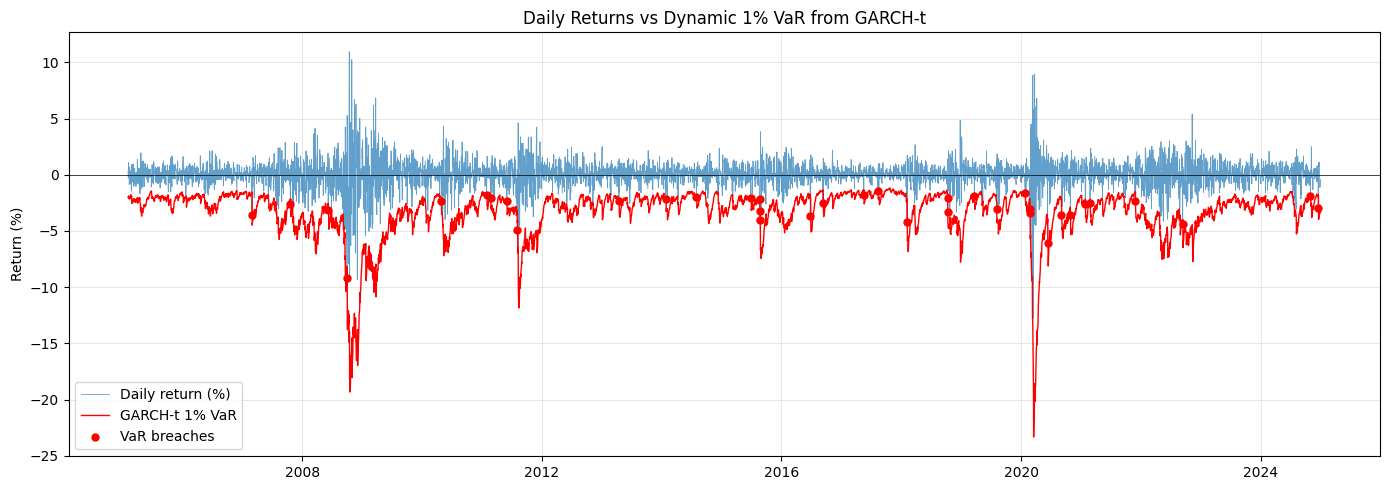

In [15]:
# Work in % returns (same scale as GARCH estimation)
ret_pct = df["SPX_Return"] * 100

# Use only dates where we have a forecasted sigma (sigma_f_pct)
mask = df["sigma_f_pct"].notna()

# Extract estimated mean and degrees of freedom from GARCH-t
params = res.params
mu_hat = params["mu"]      # mean (in %)
nu_hat = params["nu"]      # t degrees of freedom

# ------------------------------------------------------------
# Step 1: Compute time-varying 1% and 0.1% VaR
# ------------------------------------------------------------
alpha_1 = 0.01    # 1% left tail
alpha_01 = 0.001  # 0.1% left tail

# Quantiles of the t distribution (negative numbers)
q_1  = student_t.ppf(alpha_1,  df=nu_hat)
q_01 = student_t.ppf(alpha_01, df=nu_hat)

# Dynamic VaR forecasts based on one-step-ahead sigma (sigma_f_pct)
df.loc[mask, "VaR_1pct_t"]  = mu_hat + df.loc[mask, "sigma_f_pct"] * q_1
df.loc[mask, "VaR_01pct_t"] = mu_hat + df.loc[mask, "sigma_f_pct"] * q_01

# ------------------------------------------------------------
# Step 2: Count VaR breaches (calibration check)
# ------------------------------------------------------------
eval_df = df.loc[mask, ["VaR_1pct_t", "VaR_01pct_t"]].copy()
eval_df["Return_pct"] = ret_pct.loc[mask]

n_eval = len(eval_df)

# Indicators: did the realised return fall below the predicted VaR?
eval_df["Breach_1pct"]  = (eval_df["Return_pct"] <= eval_df["VaR_1pct_t"]).astype(int)
eval_df["Breach_01pct"] = (eval_df["Return_pct"] <= eval_df["VaR_01pct_t"]).astype(int)

n_breach_1  = int(eval_df["Breach_1pct"].sum())
n_breach_01 = int(eval_df["Breach_01pct"].sum())

freq_breach_1  = n_breach_1  / n_eval
freq_breach_01 = n_breach_01 / n_eval

print(f"Number of evaluation days: {n_eval}")
print("\nDynamic VaR breach frequencies (GARCH-t):")
print(f"  1% VaR:   {n_breach_1} breaches "
      f"({freq_breach_1*100:.2f}% of days; nominal = 1.00%)")
print(f"  0.1% VaR: {n_breach_01} breaches "
      f"({freq_breach_01*100:.2f}% of days; nominal = 0.10%)")

# ------------------------------------------------------------
# Step 3: Plot returns vs dynamic 1% VaR
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(eval_df.index, eval_df["Return_pct"], lw=0.6, alpha=0.7, label="Daily return (%)")
ax.plot(eval_df.index, eval_df["VaR_1pct_t"], color="red", lw=1.0, label="GARCH-t 1% VaR")

# Highlight VaR breaches
breach_dates = eval_df.index[eval_df["Breach_1pct"] == 1]
ax.scatter(breach_dates,
           eval_df.loc[breach_dates, "Return_pct"],
           color="red", s=25, zorder=3, label="VaR breaches")

ax.axhline(0, color="black", lw=0.5)
ax.set_ylabel("Return (%)")
ax.set_title("Daily Returns vs Dynamic 1% VaR from GARCH-t")
ax.grid(True, alpha=0.3)
ax.legend(loc="lower left")

plt.tight_layout()
plt.show()


The dynamic one-day VaR forecasts from the GARCH(1,1)–t model are reasonably well calibrated. Over 5,012 evaluation days, the **1% VaR** is breached **37 times** (0.74% of days) versus a nominal rate of 1%, so the model is slightly **conservative** at this level: realised losses exceed the VaR threshold a bit less often than expected. For the more extreme **0.1% VaR**, we observe **6 breaches** (0.12% of days), which is very close to the nominal 0.10% rate. The time-series plot shows that these VaR breaches are not randomly scattered: they cluster during known crisis periods (2008–2009 and March 2020), when the VaR band widens dramatically along with observed volatility. Together, this suggests that the GARCH-t model produces **plausible, crisis-sensitive tail-risk forecasts** that are broadly consistent with the empirical frequency of extreme returns.


### 2.5 Relating Modelled Risk to VIX and Realised Volatility
**Question:** Does our model-implied tail risk line up with external indicators of fear and turbulence?

- **What we do:**  
  - Plot `CrashProb_5pct` and/or dynamic VaR together with:
    - VIX level,  
    - realised volatility.  
  - Compute simple correlations or just visually highlight episodes where all three spike.
- **Why:**  
  - VIX and realised volatility are widely used risk indicators; if our model agrees with them, that supports its **external validity**.
- **What we can say:**  
  - “Periods where the model assigns high crash probability coincide with high VIX and high realised volatility, suggesting that the GARCH-t model captures the same high-risk regimes that traders and historical measures identify.”

---

Available columns: ['CrashProb_5pct', 'VaR_1pct_t', 'VIX_Close', 'RV_20d_ann', 'GARCH_vol_annual']


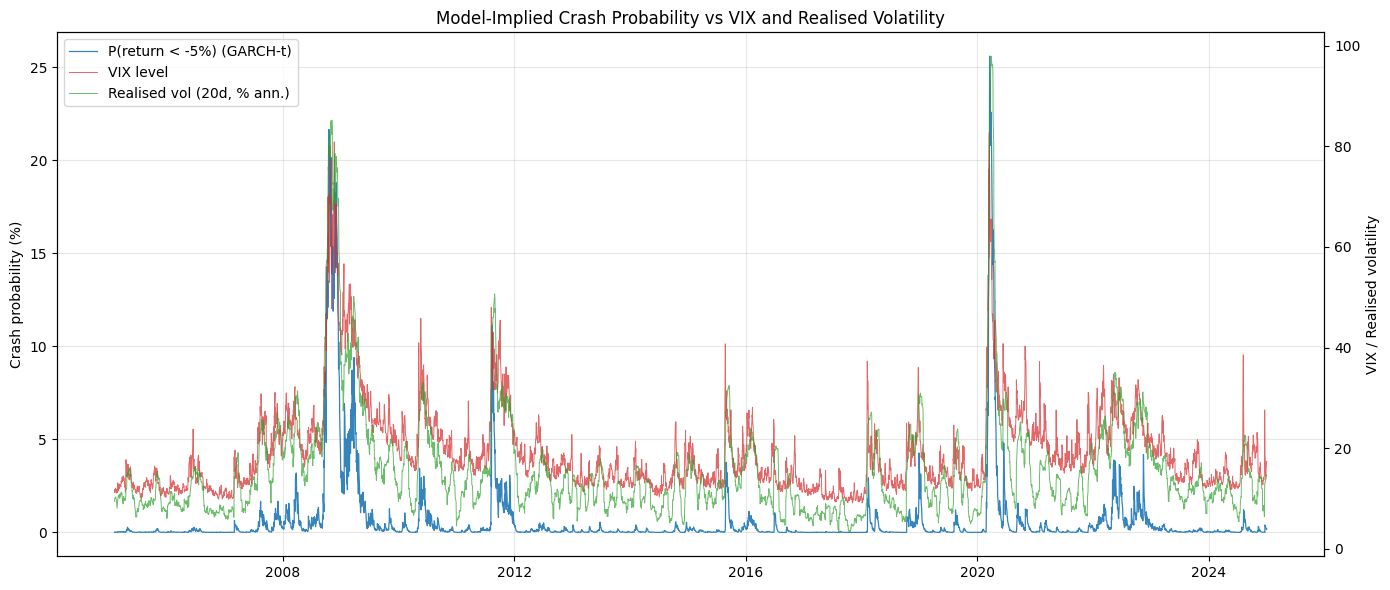

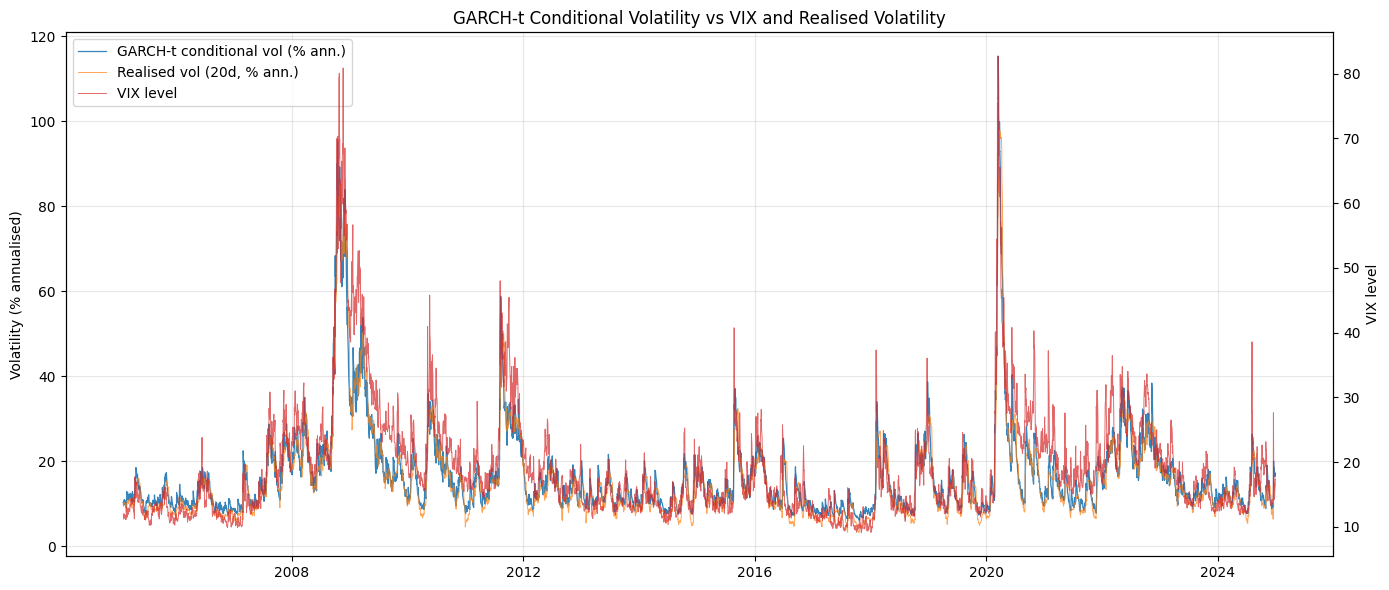


Correlation matrix:
                  CrashProb_5pct  GARCH_vol_annual  RV_20d_ann  VIX_Close
CrashProb_5pct          1.000000          0.903328    0.884599   0.779229
GARCH_vol_annual        0.903328          1.000000    0.967466   0.898236
RV_20d_ann              0.884599          0.967466    1.000000   0.887143
VIX_Close               0.779229          0.898236    0.887143   1.000000


In [16]:
# Make sure the key columns exist and are aligned
cols_needed = ["CrashProb_5pct", "VaR_1pct_t",
               "VIX_Close", "RV_20d_ann", "GARCH_vol_annual"]
print("Available columns:", [c for c in cols_needed if c in df.columns])

mask = df["CrashProb_5pct"].notna()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Left axis: crash probability (convert to % for readability)
ax1.plot(df.index[mask],
         df.loc[mask, "CrashProb_5pct"] * 100,
         lw=0.9, alpha=0.9,
         label="P(return < -5%) (GARCH-t)")
ax1.set_ylabel("Crash probability (%)")
ax1.grid(True, alpha=0.3)

# Right axis: VIX and realised volatility
ax2 = ax1.twinx()
ax2.plot(df.index[mask],
         df.loc[mask, "VIX_Close"],
         color="tab:red", lw=0.7, alpha=0.7,
         label="VIX level")
ax2.plot(df.index[mask],
         df.loc[mask, "RV_20d_ann"] * 100,
         color="tab:green", lw=0.7, alpha=0.7,
         label="Realised vol (20d, % ann.)")

ax2.set_ylabel("VIX / Realised volatility")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.set_title("Model-Implied Crash Probability vs VIX and Realised Volatility")
plt.tight_layout()
plt.show()

# ============================================================
# PLOT: GARCH-t conditional vol vs VIX and realised vol
# ============================================================

mask_vol = df["GARCH_vol_annual"].notna()

fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.plot(df.index[mask_vol],
         df.loc[mask_vol, "GARCH_vol_annual"] * 100,
         lw=0.9, alpha=0.9,
         label="GARCH-t conditional vol (% ann.)")
ax1.plot(df.index[mask_vol],
         df.loc[mask_vol, "RV_20d_ann"] * 100,
         lw=0.7, alpha=0.7,
         label="Realised vol (20d, % ann.)")
ax1.set_ylabel("Volatility (% annualised)")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(df.index[mask_vol],
         df.loc[mask_vol, "VIX_Close"],
         color="tab:red", lw=0.7, alpha=0.7,
         label="VIX level")
ax2.set_ylabel("VIX level")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.set_title("GARCH-t Conditional Volatility vs VIX and Realised Volatility")
plt.tight_layout()
plt.show()

# ============================================================
# CORRELATIONS: crash prob / GARCH vol / realised vol / VIX
# ============================================================

corr_df = df[["CrashProb_5pct",
              "GARCH_vol_annual",
              "RV_20d_ann",
              "VIX_Close"]].dropna()

corr_matrix = corr_df.corr()
print("\nCorrelation matrix:")
print(corr_matrix)


#### Relating Model-Implied Risk to VIX and Realised Volatility

The first plot compares the **model-implied crash probability** $P(r_{t+1} < -5\%)$ with the **VIX level** and **20-day realised volatility**. As expected, the crash probability is numerically much smaller (it is a probability, not a volatility measure), but its **spikes line up with periods of elevated VIX and high realised volatility**, especially during the 2008–2009 financial crisis and the March 2020 COVID shock. In quiet markets, VIX, realised volatility, and the crash probability all fall back towards low levels, indicating a benign risk environment.

The second plot compares **GARCH-t conditional volatility** with the same two benchmarks. Here the model’s volatility estimate tracks both realised volatility and VIX very closely through time: all three series rise and fall together across different regimes, with large, synchronized spikes in major stress episodes.

The correlation matrix quantifies these relationships. Crash probability is very highly correlated with GARCH volatility (**ρ ≈ 0.90**) and realised volatility (**ρ ≈ 0.88**), and strongly correlated with VIX (**ρ ≈ 0.78**). GARCH volatility itself is almost perfectly correlated with realised volatility (**ρ ≈ 0.97**) and strongly correlated with VIX (**ρ ≈ 0.90**). Together, the plots and correlations show that when our model signals elevated crash risk or high conditional volatility, the market is also pricing in high uncertainty (via VIX) and recent returns have been unusually turbulent. This provides **external validation** for the GARCH-t framework: it identifies the same high-risk periods that standard volatility measures and market participants regard as dangerous.


### 2.6 Discussion: Predictability vs. Awareness of Black Swans
**Question:** What have we actually achieved with this modelling, given Taleb’s argument that black swans are fundamentally unpredictable?

- **What we do:**  
  - Reflect on the limits: the model reacts to volatility and can signal **fragile regimes**, but cannot foresee new, unprecedented shocks.  
  - Connect back to the “Fourth Quadrant” idea: in such domains, the goal is not perfect forecasting but **robust awareness of tail risk**.
- **Why:**  
  - This frames your results correctly: you’re not claiming to “predict black swans”, but to **avoid the Gaussian illusion** that they are impossible.
- **What we can say:**  
  - “Our results show that heavy-tailed GARCH models can dynamically identify periods of elevated crash risk and produce realistic tail-risk forecasts, but they cannot predict the specific timing or trigger of black swan events. This aligns with Taleb’s view: in the Fourth Quadrant, the main danger is relying on thin-tailed models that underestimate extremes, not the absence of a perfect predicting machine.”
